In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import requests, zipfile, io

# Set up plotting style (optional)
plt.style.use('default')
sns.set_palette("husl")

# Loading Dataset

In [275]:
# Retrieve and Unzip Dataset Into Local Environment
url = 'https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%205/Day%205%20-%20Mini%20Project/UCI%20Heart%20Disease%20Data.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

In [276]:
# Load Dataset as Pandas Dataframe
df = pd.read_csv('.\\data\\heart_disease_uci.csv')
print(df.shape)
print('=' * 75)
print(df.head())
print('=' * 75)
print(df.info())

(920, 16)
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0 

# Data Preparation

In [277]:
# Remove Duplicates
df = df.drop_duplicates()

# Missing Values
print(df.isna().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [278]:
# Handle Missing/Nonsensical Values for Chol
df['chol'] = df['chol'].replace(0, np.nan) # Convert 0's to Missing Values

# Replace Missing Values with Median
df['chol'] = df['chol'].fillna(df['chol'].median())

# Check 
df['chol'].isna().sum()

np.int64(0)

In [279]:
# Handle Missing/Nonsensical Values for trestbps
df['trestbps'] = df['trestbps'].replace(0, np.nan) # Convert 0's to Missing Values

# Replace Missing Values with Median
df['trestbps'] = df['trestbps'].fillna(df['trestbps'].median())

# Check
df['trestbps'].isna().sum()

np.int64(0)

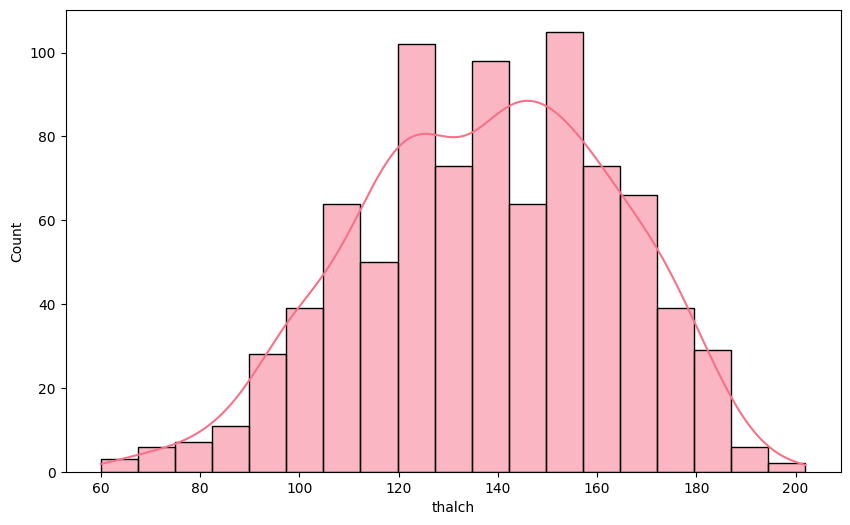

0


In [280]:
# Handle Missing/Nonsensical Values for thalc
df['thalch'].value_counts(dropna=False).sort_index()

# View Distribution of Thalch
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='thalch', kde=True)
plt.show()

# As Thalch is Roughly Normally Distributed, we will use Mean to Impute
df['thalch'] = df['thalch'].fillna(df['thalch'].mean())

# Check
print(df['thalch'].isna().sum())

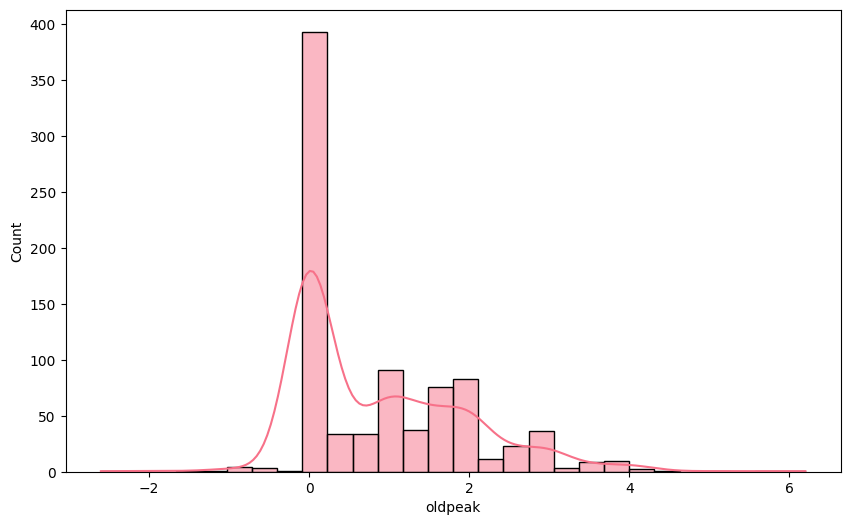

12 62
0


In [281]:
# View Distribution of oldpeak
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='oldpeak', kde=True)
plt.show()

# Handling 'oldpeak' values
df['oldpeak'].describe()
print((df['oldpeak'] < 0).sum(), df['oldpeak'].isna().sum())  # ST depression can’t be negative

# Ensure that any value less than 0 will be 0
df['oldpeak'] = df['oldpeak'].clip(lower=0)

# Fill Null Values with the Median
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].median())

# Check
print(df['oldpeak'].isna().sum())

In [282]:
# Fill Missing Values for Categorical Columns With Their Respective Modes
categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Replace missing values in the original DataFrame
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Check
print(df.isna().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalch        0
exang         0
oldpeak       0
slope         0
ca          611
thal          0
num           0
dtype: int64


C:\Users\nivya\AppData\Local\Temp\ipykernel_12188\2811162126.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])


In [283]:
# Map 'Sex' Column to 1 and 0
df['sex'] = df['sex'].map({'Male' : 1, 'Female' : 0})

# Map Bool Columns (fbs, exang) to 1/0
bool_cols = ['exang', 'fbs']
df[bool_cols] = df[bool_cols].astype('int64')

In [284]:
# View Column Types/Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    int64  
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    int64  
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    int64  
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        309 non-null    float64
 14  thal      920 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(6), object(5)
memory usage: 115.1+ KB


In [285]:
# One-Hot Encoding for Categorical Columns
# List of categorical columns
categorical_cols = ['thal', 'slope', 'cp', 'restecg', 'dataset']

# One-hot encode these columns and keep everything else
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)  # drop_first=False keeps all categories

# Check
print(df.shape)
print(df.info())

(920, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        920 non-null    int64  
 1   age                       920 non-null    int64  
 2   sex                       920 non-null    int64  
 3   trestbps                  920 non-null    float64
 4   chol                      920 non-null    float64
 5   fbs                       920 non-null    int64  
 6   thalch                    920 non-null    float64
 7   exang                     920 non-null    int64  
 8   oldpeak                   920 non-null    float64
 9   ca                        309 non-null    float64
 10  num                       920 non-null    int64  
 11  thal_fixed defect         920 non-null    bool   
 12  thal_normal               920 non-null    bool   
 13  thal_reversable defect    920 non-null    bool   
 14  

In [286]:
# Now that all of the Data is clean, we can use KNN to fill in Missing Values for 'ca' column
from sklearn.impute import KNNImputer

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=3)  # n_neighbors can be adjusted

# KNNImputer works on numeric arrays, so we can impute the whole DataFrame
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

# Ensure that ca is a round number
df_imputed['ca'] = df_imputed['ca'].round().astype(int)

# Check missing values
print(df_imputed['ca'].shape)

# Apply the Change to Original Dataframe
df['ca'] = df_imputed['ca']

# Final Check
print(df.info())

(920,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        920 non-null    int64  
 1   age                       920 non-null    int64  
 2   sex                       920 non-null    int64  
 3   trestbps                  920 non-null    float64
 4   chol                      920 non-null    float64
 5   fbs                       920 non-null    int64  
 6   thalch                    920 non-null    float64
 7   exang                     920 non-null    int64  
 8   oldpeak                   920 non-null    float64
 9   ca                        920 non-null    int64  
 10  num                       920 non-null    int64  
 11  thal_fixed defect         920 non-null    bool   
 12  thal_normal               920 non-null    bool   
 13  thal_reversable defect    920 non-null    bool   
 14  slo

In [287]:
# Scaling Features using Standard Scaler
# Instantiate StandardScaler Object
scaler = StandardScaler()

# Choose Only Numeric Columns to Scale
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Fit the scaler and transform
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check
print(df.head())

   id       age  sex  trestbps      chol  fbs    thalch  exang   oldpeak  \
0   1  1.007386    1  0.717803 -0.236157    1  0.495698      0  1.382554   
1   2  1.432034    1  1.554856  0.787855    0 -1.175955      1  0.610681   
2   3  1.432034    1 -0.677285 -0.313441    0 -0.340128      1  1.672006   
3   4 -1.752828    1 -0.119250  0.092300    0  1.968345      0  2.540363   
4   5 -1.328180    0 -0.119250 -0.796466    0  1.371326      0  0.514197   

         ca  ...  cp_atypical angina  cp_non-anginal  cp_typical angina  \
0 -0.943633  ...               False           False               True   
1  3.196951  ...               False           False              False   
2  1.816756  ...               False           False              False   
3 -0.943633  ...               False            True              False   
4 -0.943633  ...                True           False              False   

   restecg_lv hypertrophy  restecg_normal  restecg_st-t abnormality  \
0                    

# Model Training

In [288]:
# Since we are only checking whether or not a patient has heart disease, we will change the Target Column ('num') to Binary
# Check Values Before 
print('Before:\n', df['num'].value_counts())

# Apply Binary Classification to Either Has (1) or Doesn't (0) have heart disease
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Check
print('\nAfter:\n', df['num'].value_counts())

Before:
 num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

After:
 num
1    509
0    411
Name: count, dtype: int64


In [289]:
# Split the Dataset into a Training Set and Testing Set
# Step 1: Separate Target (y) from Features (X)
X = df.drop(columns='num', axis=1)
y = df['num']


# Step 2: Split the data into Training/Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# Check to Ensure Split Worked Properly
print(X_train.shape, X_test.shape)

(736, 27) (184, 27)


In [290]:
# Create Instance of a Logistic Regression Model
model = LogisticRegression(max_iter=1500)

# Fit Model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Check
print(y_pred.shape)

(184,)


# Model Evaluation

In [291]:
# Evaluate the Predictions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.842391304347826

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82        82
           1       0.85      0.86      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184


Confusion Matrix:
 [[67 15]
 [14 88]]


## Interpretation and Conclusions

- ### Accuracy (Correct Predictions / Total Predictions)
    Correct Predictions = TP (88) + TN (67) / TP + TN + FP + FN = 84.24%

- ### Precision (Of all samples the model predicted as positive (1), how many were actually positive?)
    Precision = TP (88) / TP (88) + FP (15) = 85.44%

- ### Recall (Of all actual positives, how many did the model correctly identify?)
    Recall = TP (88) / TP (88) + FN (14) = 86.3%